# Set up

In [1]:
import pandas as pd
import hmmlearn as hmm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [2]:
raw_data = pd.read_csv('returns_20181228.csv',index_col='Date')

The dataset includes in total 1140 stocks and 998 trading days

In [3]:
raw_data.index = pd.to_datetime(raw_data.index)

In [4]:
print(raw_data.shape)

raw_data.head()

(998, 1140)


,stock_0,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,stock_9,...,stock_1131,stock_1132,stock_1133,stock_1134,stock_1135,stock_1136,stock_1137,stock_1138,stock_1139,stock_1140
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-03,-0.561639,0.113423,-1.580584,-0.017527,1.055723,1.306785,-0.692687,1.303057,-0.243042,0.081520,...,1.410213,-0.307705,0.829215,-0.505364,0.232976,-0.393465,-0.471561,-0.308961,-0.202832,-0.205398
1990-01-04,-1.841947,0.463435,-1.172764,0.513875,2.470817,0.463057,0.427191,-0.737959,1.455408,0.971196,...,-0.656517,-1.327001,0.770307,0.485192,-0.199085,-0.590958,-0.513262,0.369685,-0.549467,0.279644
1990-01-05,-0.277859,0.216396,-0.429848,0.802112,2.686740,0.059472,-0.895917,-0.785620,0.022776,-1.336882,...,0.098997,0.197211,-2.003799,2.101860,0.442342,-0.677487,-0.955708,0.926602,-0.762952,2.046626
1990-01-08,-0.881483,1.867996,-1.659936,0.313561,0.868181,-1.923021,-1.788387,2.902709,0.600026,-0.943956,...,-0.366244,0.480905,-0.780784,-0.131875,-0.657870,-1.526045,-0.140225,1.410707,0.168989,0.787590
1990-01-09,-0.534578,0.413210,0.004407,1.223128,0.972728,1.420754,1.864039,1.564482,0.243046,1.345295,...,1.469816,0.017081,-1.603788,-2.895389,0.540079,-1.126372,-1.737689,1.036790,1.243899,0.069950


# Data Preprocessing

## Missing data 

There can be multiple forms of missing data:


1. Missing dates: 1992-04-21

2. Constant values(0) for an extended period, probably due to stock delisting or company bankruptcy. These stocks should be removed

3. NA values

### Missing dates

1. **1992-04-21 data is missing in this dataset**

2. The dates in this dataset do not follow NYSE trading calendar and instead follows business calendar

In [5]:
business_calendar=pd.date_range(raw_data.index[0],raw_data.index[-1],freq='B')
print('There are ',len(business_calendar),'business days between start date and ending date of the dataset')



There are  999 business days between start date and ending date of the dataset


In [6]:
business_calendar.difference(raw_data.index)

DatetimeIndex(['1992-04-21'], dtype='datetime64[ns]', freq=None)

### Constant values

Identify consecutive duplicates in a list

In [6]:
[(k,sum(1 for i in g)) for k,g in groupby([1,1,1,2,2,3])]

[(1, 3), (2, 2), (3, 1)]

In [1]:
from itertools import groupby
def num_constants(L):
    # number of consecutive duplicates in a list
    res = [(k,sum(1 for i in g)) for k,g in groupby(L)]
    # return max number of duplicates
    return sorted(res,key=lambda x: x[1],reverse=True)[0][1]


**110** stocks are delisted during the time period of the dataset and should be removed

In [8]:
duplicates = raw_data.loc[:,raw_data.apply(num_constants,axis=0)>2]
print(duplicates.shape)
duplicates.tail(10)

(998, 110)


,stock_5,stock_40,stock_54,stock_71,stock_74,stock_78,stock_82,stock_86,stock_90,stock_95,...,stock_900,stock_917,stock_931,stock_934,stock_936,stock_942,stock_973,stock_988,stock_992,stock_993
Date,,,,,,,,,,,,,,,,,,,,,
1993-10-19,0.0,0.0,0.0,0.0,0.0,0.0,0.909097,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-10-20,0.0,0.0,0.0,0.0,0.0,0.0,0.264709,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-10-21,0.0,0.0,0.0,0.0,0.0,0.0,-1.813616,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-10-22,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-10-25,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-10-26,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-10-27,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-10-28,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-10-29,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
data1 = raw_data.loc[:,raw_data.apply(num_constants,axis=0)<=1]
data1.shape

(998, 1030)

### NA values

- Less than 10% of the data(stocks/days) have missing values

- No clear pattern in the missing data

- Due to time limitation, we can just use linear interpolation to fill in the missing values, i.e. replace NA with average of the neighboring points

In [10]:
print('Number of stocks with missing return values {}'.format(sum(data1.isna().sum(axis=0))))
print('Number of days with missing return values {}'.format(sum(data1.isna().sum(axis=1))))

Number of stocks with missing return values 84
Number of days with missing return values 84


Missing values in each stock

In [11]:
print(data1.columns[data1.isna().sum(axis=0)!=0])

Index(['stock_8', 'stock_18', 'stock_21', 'stock_79', 'stock_81', 'stock_85',
       'stock_108', 'stock_123', 'stock_130', 'stock_133', 'stock_136',
       'stock_144', 'stock_157', 'stock_172', 'stock_181', 'stock_208',
       'stock_210', 'stock_213', 'stock_214', 'stock_234', 'stock_241',
       'stock_247', 'stock_259', 'stock_264', 'stock_299', 'stock_310',
       'stock_312', 'stock_318', 'stock_337', 'stock_353', 'stock_367',
       'stock_376', 'stock_380', 'stock_381', 'stock_405', 'stock_410',
       'stock_421', 'stock_431', 'stock_433', 'stock_437', 'stock_442',
       'stock_448', 'stock_470', 'stock_472', 'stock_474', 'stock_476',
       'stock_487', 'stock_491', 'stock_495', 'stock_500', 'stock_503',
       'stock_512', 'stock_541', 'stock_549', 'stock_571', 'stock_573',
       'stock_580', 'stock_600', 'stock_615', 'stock_676', 'stock_689',
       'stock_720', 'stock_756', 'stock_762', 'stock_780', 'stock_782',
       'stock_795', 'stock_800', 'stock_801', 'stock_851',

Missing values in each day of week

In [12]:
print(data1.index.dayofweek[data1.isna().sum(axis=1)!=0].value_counts())
print(data1.index.to_period('Q')[data1.isna().sum(axis=1)!=0].value_counts())

0    22
2    16
1    16
4    14
3    14
Name: Date, dtype: int64
1992Q3    9
1993Q3    8
1993Q1    7
1990Q2    7
1992Q1    6
1993Q2    5
1992Q4    5
1991Q4    5
1991Q2    5
1990Q4    5
1992Q2    4
1991Q1    4
1990Q1    4
1991Q3    3
1990Q3    3
1993Q4    2
Freq: Q-DEC, Name: Date, dtype: int64


In [9]:
data2 = data1.interpolate(method='linear')

## Data anomaly

1. The max/min values seems to be reasonable 

2. The mean returns of some stocks seem anomalous

3. The mean returns of different days look normal

4. Point anomalies are difficult to pinpoint considering the fact that stock returns are very volatile

In [14]:
print('max: ',max(data2.max(axis=1)))
print('min: ',min(data2.min(axis=1)))

max:  18.8587342496
min:  -7.69175034152


**The histogram of mean returns suggests that there're some outlying stocks** - we can use 2-cluster K-Means to identify the outliers

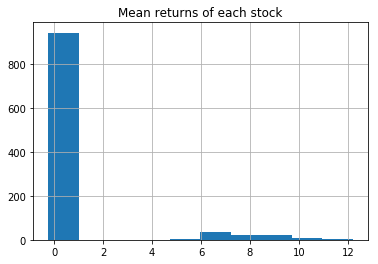

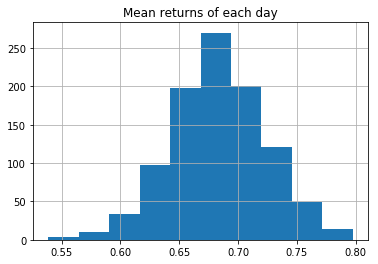

In [15]:
plt.title('Mean returns of each stock')
data2.mean(axis=0).hist()
plt.figure()
plt.title('Mean returns of each day')
data2.mean(axis=1).hist()

Two clusters of stocks have distinctly distributions

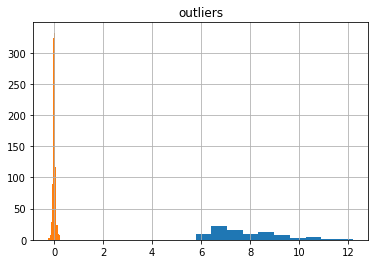

In [11]:
from sklearn.cluster import KMeans
res = KMeans(n_clusters=2,random_state=1234).fit_predict(data2.T)
plt.figure()
plt.title('outliers')
data2.loc[:,res.astype(bool)].mean(axis=0).hist()
data2.loc[:,~res.astype(bool)].mean(axis=0).hist()

In [12]:
data3 = data2.loc[:,~res.astype(bool)]
data3.shape

(998, 941)

**The stock returns fit fat-tailed normal distribution pretty well, suggesting low likelihood of having point anomaliies**

In [18]:
# construct normal distribution using mean and standard deviation of the data
from scipy.stats import norm
a = data3.values.flatten().mean()
b = data3.values.flatten().std()

x = np.linspace(-10,10,1000)
y = norm.pdf(x, loc=a, scale=b)

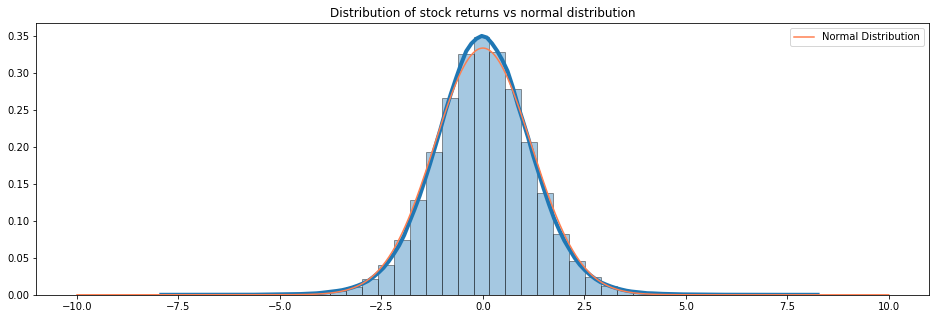

In [19]:
plt.figure(figsize=(16, 5))
plt.title('Distribution of stock returns vs normal distribution')
sns.distplot(data3.values.flatten(), hist=True, kde=True, 
             bins=40, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
sns.lineplot(x,y, color="coral",label='Normal Distribution')

# Regime shift detection


## Stationarity diagnostics

Using augmented dicky fuller test to confirm that the stock return series are stationary

In [20]:
from statsmodels.tsa.stattools import adfuller

def adfuller_w_crit_val(x,crit_val=0.01):
    # determine if the time series is stationary or not with given critical value
    result = adfuller(x)
    return result[1]<crit_val


stationarity = data3.apply(adfuller_w_crit_val,axis=0)
sum(stationarity)==data3.shape[1]

True

## Detect autocorrelation break point

**1992-4-23 is the breakpoint**

ruptures: a Python library for off-line change point detection

http://ctruong.perso.math.cnrs.fr/ruptures-docs/build/html/costs/costautoregressive.html

https://arxiv.org/abs/1801.00718


Let 0<$t_1$<$t_2$<⋯<n be unknown change points indexes. Consider the following piecewise autoregressive model

$y_t=z_t \delta j+\epsilon_t$,$\forall t=t_j,…,t_{j+1}$
where j>1 is the segment number, $z_t=[y_{t−1},y_{t−2},…,y_{t−p}]$ is the lag vector,and p>0 is the order of the process.

The least-squares estimates of the break dates is obtained by minimiming the sum of squared residuals . Formally, the associated cost function on an interval $\mathbb{I}$ is

$c(y_I)=min_{\delta\in\mathcal{R}}\sum_{t\in I}||y_t−\delta z_t||_2^2$

In [13]:
import ruptures as rpt
def change_point_detection(x):
    algo = rpt.Dynp(model="ar", params={"order": 1})
    tmp = algo.fit_predict(x,n_bkps=1)
    return tmp[0]

In [14]:
result = data3.apply(change_point_detection,0)

/Users/yuejin/miniconda3/lib/python3.5/site-packages/ruptures/costs/costautoregressive.py:134: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  self.signal = signal.reshape(-1, 1)
/Users/yuejin/miniconda3/lib/python3.5/site-packages/ruptures/costs/costautoregressive.py:169: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  _, residual, _, _ = lstsq(X, y)


In [17]:
data3.shape

(998, 941)

In [23]:
result.value_counts().head(5)

600    408
595    120
605     87
610     45
590     40
dtype: int64

In [24]:
data3.index[[result.value_counts().head(5).index]]

DatetimeIndex(['1992-04-23', '1992-04-15', '1992-04-30', '1992-05-07',
               '1992-04-08'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [27]:
brk_pt = result.value_counts().index[0]
print("Using majority vote we can see that {} is the breakpoint".format(data3.index[result.value_counts().index[0]]))

Using majority vote we can see that 1992-04-23 00:00:00 is the breakpoint


**The lag plot confirms the claim**: 

If we choose 1992-04-23 as the breakpoint, the autocorrelation prior and post break point are distinctively separate

If we choose a random date as breakpoint, points of different collors are mixed - some orange points fall along the direction of blue points

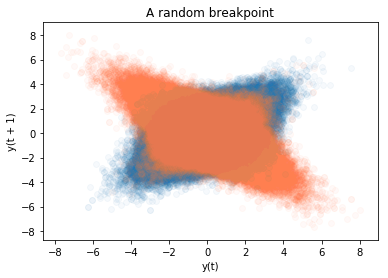

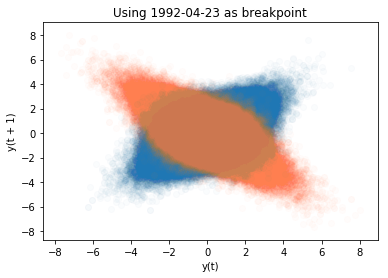

In [28]:
plt.title('A random breakpoint')
pd.plotting.lag_plot(data3.iloc[:550,],alpha=0.04)
pd.plotting.lag_plot(data3.iloc[550:,],c='coral',alpha=0.04)
plt.figure()
plt.title('Using 1992-04-23 as breakpoint')
pd.plotting.lag_plot(data3.iloc[:brk_pt,],alpha=0.02)
pd.plotting.lag_plot(data3.iloc[brk_pt:,],c='coral',alpha=0.02)

Test stationarity in different regimes

In [29]:
stationarity_1 = data3.iloc[:brk_pt,:].apply(adfuller_w_crit_val,axis=0)
stationarity_2 = data3.iloc[brk_pt:,:].apply(adfuller_w_crit_val,axis=0)
sum(stationarity_2)==sum(stationarity_1)==data3.shape[1]

True

## Calculate autocorrelation coefficient for two regimes

AR(1) coefficient in regime 1: **0.2851**

AR(1) coefficient in regime 2: **-0.4584**

In [30]:
from statsmodels.tsa.stattools import acf

def acf_coef(x):
    return acf(x,nlags=1)[1]
    
regime1 = data3.iloc[:brk_pt,:].apply(acf_coef,axis=0)
regime2 = data3.iloc[brk_pt:,:].apply(acf_coef,axis=0)

The distribution of autocorrelation coefficients under different regimes are distinctive

Text(0.5, 1.0, 'Autocorrelation coefficients in two regimes')

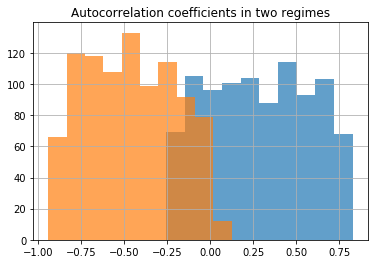

In [31]:
regime1.hist(alpha=0.7)
regime2.hist(alpha=0.7)
plt.title('Autocorrelation coefficients in two regimes')

In [32]:
print('AR(1) coefficient in regime 1: %.4f'%(np.mean(regime1)))
print('AR(1) coefficient in regime 2: %.4f'%(np.mean(regime2)))

AR(1) coefficient in regime 1: 0.2851
AR(1) coefficient in regime 2: -0.4584
